In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr


import geocat.viz as gv
import geocat.datafiles as gdf

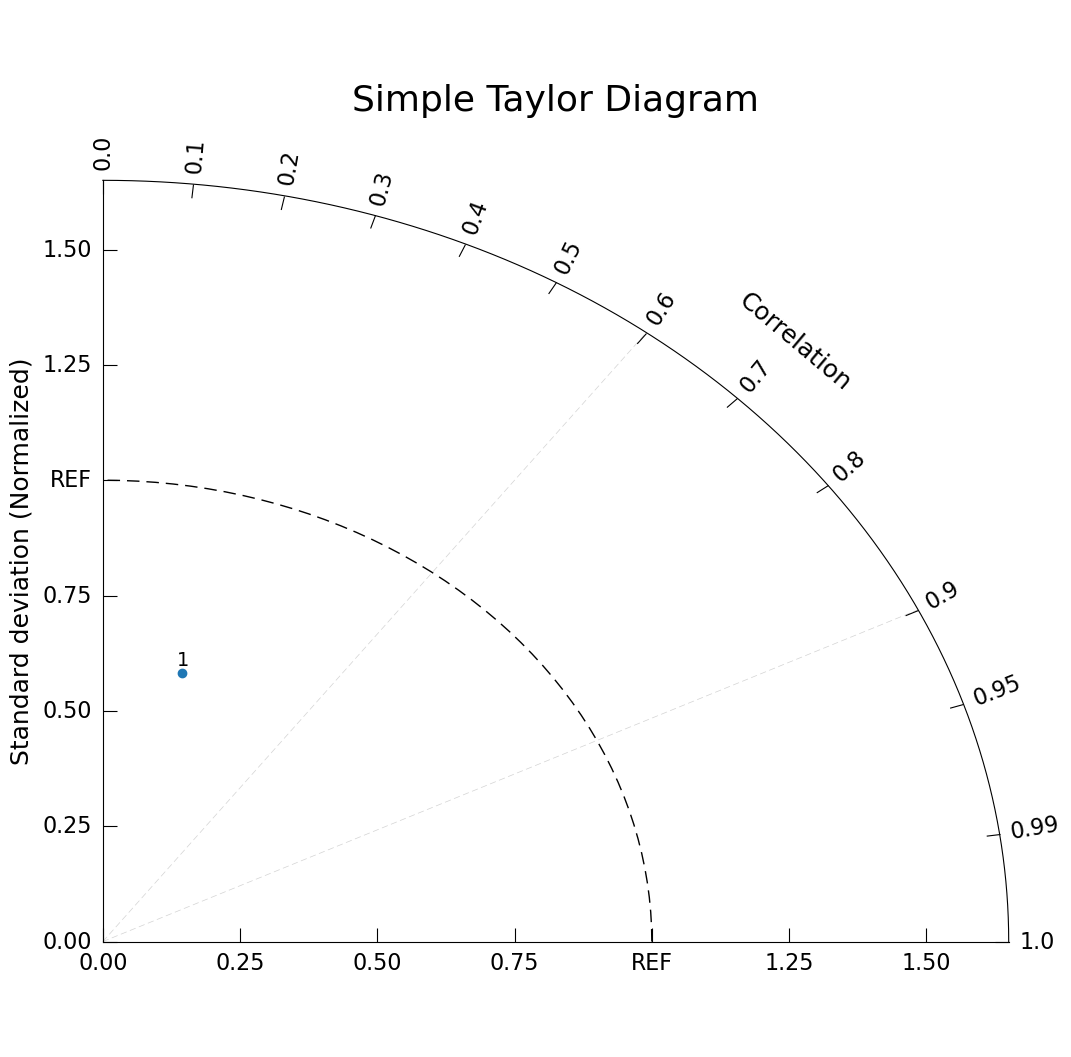

In [4]:
# Create figure and Taylor Diagram instance
fig = plt.figure(figsize=(12, 12))
taylor = gv.TaylorDiagram(fig=fig, label='REF')

# Draw diagonal dashed lines from origin to correlation values
# Also enforces proper X-Y ratio
taylor.add_xgrid(np.array([0.6, 0.9]))

# Add a model dataset of one point
taylor.add_model_set(stddev=[.6], corrcoef=[.24])

plt.title("Simple Taylor Diagram", size=26, pad=45); # Need to move title up

In [5]:
era5 = xr.open_dataset(gdf.get('netcdf_files/era5_2022_2mtemp_spres_xyav.nc'))
era5

<xarray.Dataset> Size: 129kB
Dimensions:              (initial_time0_hours: 8040)
Coordinates:
  * initial_time0_hours  (initial_time0_hours) datetime64[ns] 64kB 2022-01-01...
Data variables:
    2T_GDS0_SFC          (initial_time0_hours) float32 32kB ...
    SP_GDS0_SFC          (initial_time0_hours) float32 32kB ...

In [6]:
# Change hourly data to monthly
era5 = era5.rename({'initial_time0_hours': 'time'}) # Changing dimension name for convenience
era5_resampled = era5.resample(time='MS').mean()
offset = pd.tseries.frequencies.to_offset('15D') # use offsest to adjust to the center of each month as in CMIP5 data
era5_resampled['time'] = era5_resampled.get_index('time') + offset

era5_resampled

<xarray.Dataset> Size: 192B
Dimensions:      (time: 12)
Coordinates:
  * time         (time) datetime64[ns] 96B 2022-01-16 2022-02-16 ... 2022-12-16
Data variables:
    2T_GDS0_SFC  (time) float32 48B 277.2 277.0 277.1 nan ... 279.2 277.7 277.7
    SP_GDS0_SFC  (time) float32 48B 9.666e+04 9.664e+04 ... 9.655e+04 9.67e+04

In [7]:
era5_temp = era5_resampled['2T_GDS0_SFC'] # Because this variable name starts with a number `era5_resampled.2T_GDS0_SFC` would give an error s

# Take a look at our final temperature data
era5_temp

<xarray.DataArray '2T_GDS0_SFC' (time: 12)> Size: 48B
array([277.24756, 277.00116, 277.1267 ,       nan, 279.67548, 281.2928 ,
       281.5387 , 281.20755, 280.13947, 279.15546, 277.72687, 277.6502 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 96B 2022-01-16 2022-02-16 ... 2022-12-16
Attributes:
    long_name:  2 meter Temperature
    units:      K

In [8]:
tas_rcp85 = xr.open_dataset(gdf.get('netcdf_files/tas_Amon_CanESM2_rcp85_2022_xyav.nc'))

tas_rcp85

<xarray.Dataset> Size: 344B
Dimensions:  (time: 12)
Coordinates:
  * time     (time) object 96B 2022-01-16 12:00:00 ... 2022-12-16 12:00:00
    height   float64 8B ...
Data variables:
    r1i1p1   (time) float32 48B ...
    r2i1p1   (time) float32 48B ...
    r3i1p1   (time) float32 48B ...
    r4i1p1   (time) float32 48B ...
    r5i1p1   (time) float32 48B ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    original_name:     ST
    cell_methods:      time: mean (interval: 15 minutes)
    cell_measures:     area: areacella
    history:           2011-03-10T05:13:26Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...
    rcp:               rcp85

In [9]:
tas_rcp85['time'] = tas_rcp85.indexes['time'].to_datetimeindex()
tas_rcp85

/tmp/ipykernel_2365286/3930724370.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  tas_rcp85['time'] = tas_rcp85.indexes['time'].to_datetimeindex()


<xarray.Dataset> Size: 344B
Dimensions:  (time: 12)
Coordinates:
  * time     (time) datetime64[ns] 96B 2022-01-16T12:00:00 ... 2022-12-16T12:...
    height   float64 8B ...
Data variables:
    r1i1p1   (time) float32 48B ...
    r2i1p1   (time) float32 48B ...
    r3i1p1   (time) float32 48B ...
    r4i1p1   (time) float32 48B ...
    r5i1p1   (time) float32 48B ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    original_name:     ST
    cell_methods:      time: mean (interval: 15 minutes)
    cell_measures:     area: areacella
    history:           2011-03-10T05:13:26Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...
    rcp:               rcp85

In [10]:
temp_rcp85_std = []
temp_rcp85_corr = []

std_temp_obsv = float(era5_temp.std().values)

for em in list(tas_rcp85.data_vars): # for each ensemble member
    std = float(tas_rcp85[em].std().values)
    std_norm = std / std_temp_obsv

    corr= float(xr.corr(era5_temp, tas_rcp85[em]).values)

    temp_rcp85_std.append(std_norm)
    temp_rcp85_corr.append(corr)

In [14]:
temp_rcp85_std, temp_rcp85_corr

([1.0734499766985428,
  1.028118436359203,
  1.0296348914442794,
  1.0504941640646532,
  1.159018449844213],
 [0.9974852204322815,
  0.9751511812210083,
  0.99960857629776,
  0.9999055862426758,
  0.9936575889587402])

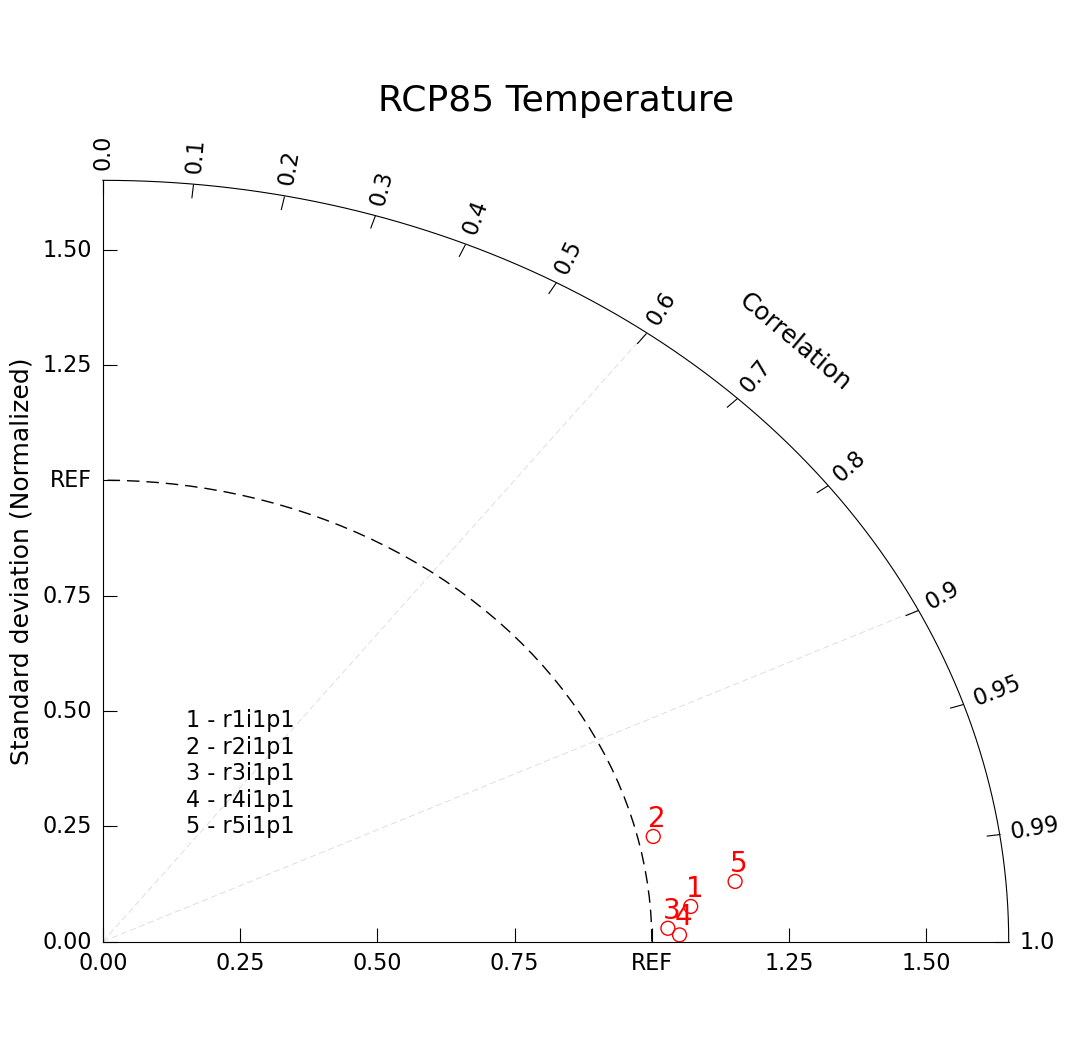

In [13]:
# Create figure and Taylor Diagram instance
fig = plt.figure(figsize=(12, 12))
taylor = gv.TaylorDiagram(fig=fig, label='REF')
ax = plt.gca()

# Draw diagonal dashed lines from origin to correlation values
# Also enforces proper X-Y ratio
taylor.add_xgrid(np.array([0.6, 0.9]))

# Add model sets for p and t datasets
taylor.add_model_set(
    temp_rcp85_std,
    temp_rcp85_corr,
    fontsize=20,  # specify font size
    xytext=(-5, 10),  # marker label location, in pixels
    color='red', # specify marker color
    marker='o', # specify marker shape
    facecolors='none', # specify marker fill
    s=100)  # marker size

# Add legend of ensemble names
namearr = list(tas_rcp85.data_vars)
taylor.add_model_name(namearr, fontsize=16)

# Add figure title
plt.title("RCP85 Temperature", size=26, pad=45);

In [15]:
# Open RCP26 and RCP45 files
tas_rcp26 = xr.open_dataset(gdf.get('netcdf_files/tas_Amon_CanESM2_rcp26_2022_xyav.nc'))
tas_rcp26['time'] = tas_rcp26.indexes['time'].to_datetimeindex()

tas_rcp45 = xr.open_dataset(gdf.get('netcdf_files/tas_Amon_CanESM2_rcp45_2022_xyav.nc'))
tas_rcp45['time'] = tas_rcp45.indexes['time'].to_datetimeindex()

/tmp/ipykernel_2365286/3755510889.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  tas_rcp26['time'] = tas_rcp26.indexes['time'].to_datetimeindex()
/tmp/ipykernel_2365286/3755510889.py:6: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  tas_rcp45['time'] = tas_rcp45.indexes['time'].to_datetimeindex()


In [16]:
# Perform statistical analysis to create our standard deviation and correlation coefficient lists
temp_rcp26_std = float(tas_rcp26['r1i1p1'].std().values) 
temp_rcp26_std_norm = temp_rcp26_std / std_temp_obsv
temp_rcp26_corr = float(xr.corr(era5_temp, tas_rcp26['r1i1p1']).values)

temp_rcp45_std = float(tas_rcp45['r1i1p1'].std().values)
temp_rcp45_std_norm = temp_rcp45_std / std_temp_obsv
temp_rcp45_corr = float(xr.corr(era5_temp, tas_rcp45['r1i1p1']).values)

temp_std = [temp_rcp26_std_norm, temp_rcp45_std_norm, temp_rcp85_std[0]]
temp_corr = [temp_rcp26_corr, temp_rcp45_corr, temp_rcp85_corr[0]]

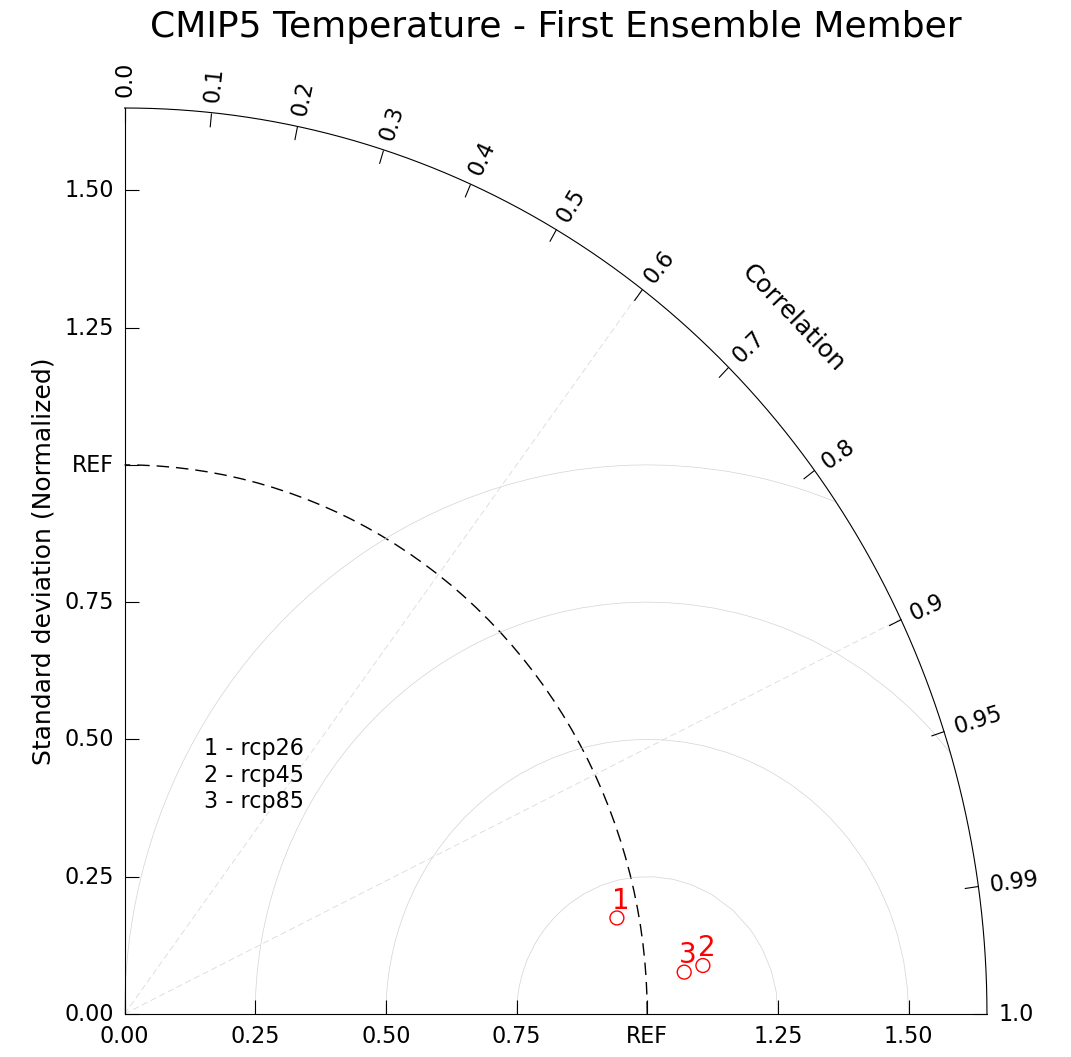

In [17]:
# Create figure and Taylor Diagram instance
fig = plt.figure(figsize=(12, 12))
taylor = gv.TaylorDiagram(fig=fig, label='REF')
ax = plt.gca()

# Draw diagonal dashed lines from origin to correlation values
# Also enforces proper X-Y ratio
taylor.add_xgrid(np.array([0.6, 0.9]))

# Add model set for temp dataset
taylor.add_model_set(
    temp_std,
    temp_corr,
    fontsize=20,
    xytext=(-5, 10),  # marker label location, in pixels
    color='red',
    marker='o',
    facecolors='none',
    s=100)  # marker size

#gv.util.set_axes_limits_and_ticks(ax, xlim=[0,2])

namearr = ['rcp26', 'rcp45', 'rcp85']
taylor.add_model_name(namearr, fontsize=16)

# Add figure title
plt.title("CMIP5 Temperature - First Ensemble Member", size=26, pad=45)

# Add constant centered RMS difference contours.
taylor.add_contours(levels=np.arange(0, 1.1, 0.25),
                 colors='lightgrey',
                 linewidths=0.5);

In [18]:
# Create sample data

# Model A
a_sdev = [1.230, 0.988, 1.092, 1.172, 1.064, 0.966, 1.079]  # normalized standard deviation
a_ccorr = [0.958, 0.973, 0.740, 0.743, 0.922, 0.982, 0.952]  # correlation coefficient

# Model B
b_sdev = [1.129, 0.996, 1.016, 1.134, 1.023, 0.962, 1.048]  # normalized standard deviation
b_ccorr = [0.963, 0.975, 0.801, 0.814, 0.946, 0.984, 0.968]  # correlation coefficient

# Sample Variable List
var_list = ['Surface Pressure', '2m Temp', 'Dew Point Temp', 'U Wind', 'V Wind', 'Precip', 'Cloud Cov']

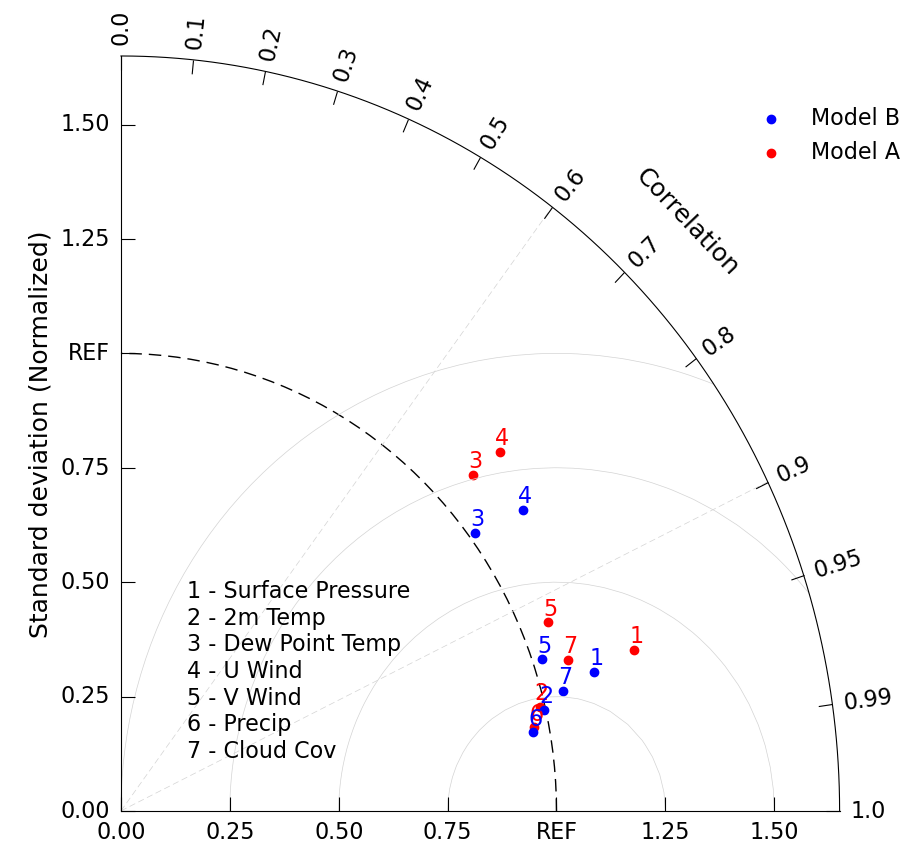

In [19]:
# Create figure and TaylorDiagram instance
fig = plt.figure(figsize=(10, 10))
taylor = gv.TaylorDiagram(fig=fig, label='REF')

# Draw diagonal dashed lines from origin to correlation values
# Also enforces proper X-Y ratio
taylor.add_xgrid(np.array([0.6, 0.9]))

# Add models to Taylor diagram
taylor.add_model_set(a_sdev,
                  a_ccorr,
                  color='red',
                  marker='o',
                  label='Model A', # add model set legend label
                  fontsize=16)

taylor.add_model_set(b_sdev,
                  b_ccorr,
                  color='blue',
                  marker='o',
                  label='Model B',
                  fontsize=16)

# Add model name
taylor.add_model_name(var_list, fontsize=16)

# Add figure legend
taylor.add_legend(fontsize=16)

# Add constant centered RMS difference contours.
taylor.add_contours(levels=np.arange(0, 1.1, 0.25),
                 colors='lightgrey',
                 linewidths=0.5);

In [20]:
# Sample corresponding bias data.

# Case A
a_bias = [2.7, -1.5, 17.31, -20.11, 12.5, 8.341, -4.7]  # bias (%)

# Case B
b_bias = [1.7, 2.5, -17.31, 20.11, 19.5, 7.341, 9.2]

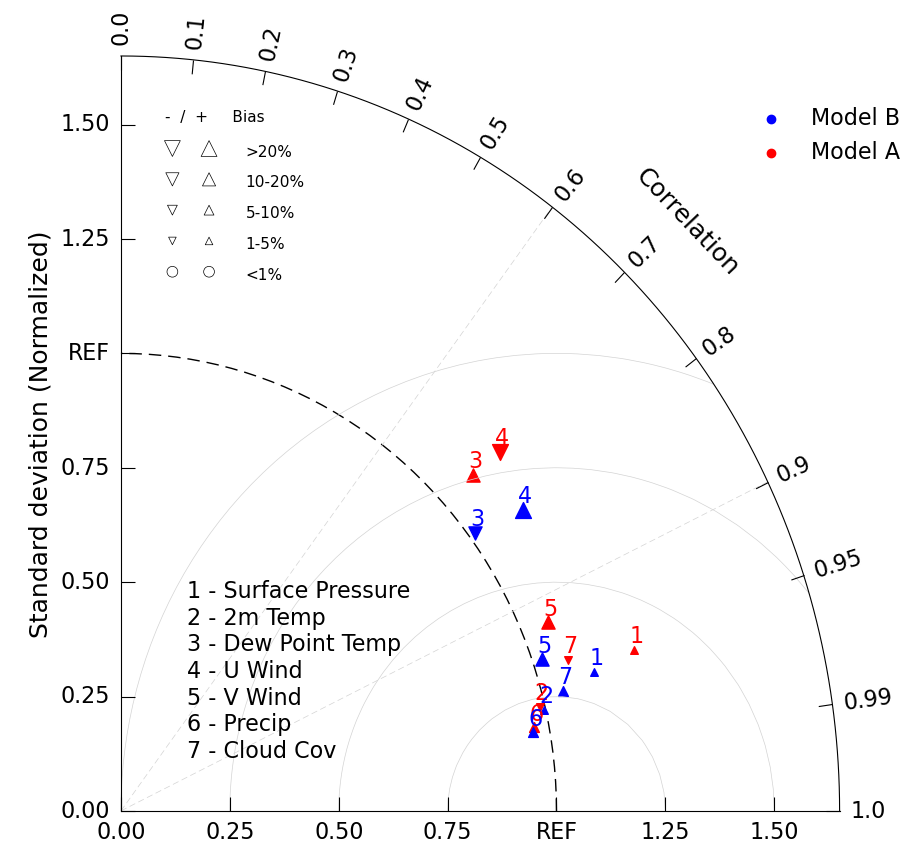

In [21]:
# Create figure and TaylorDiagram instance
fig = plt.figure(figsize=(10, 10))
taylor = gv.TaylorDiagram(fig=fig, label='REF')

# Draw diagonal dashed lines from origin to correlation values
# Also enforces proper X-Y ratio
taylor.add_xgrid(np.array([0.6, 0.9]))

# Add models to Taylor diagram
taylor.add_model_set(a_sdev,
                  a_ccorr,
                  percent_bias_on=True, # indicate marker and size to be plotted based on bias_array
                  bias_array=a_bias, # specify bias array
                  color='red',
                  label='Model A',
                  fontsize=16)

taylor.add_model_set(b_sdev,
                  b_ccorr,
                  percent_bias_on=True,
                  bias_array=b_bias,
                  color='blue',
                  label='Model B',
                  fontsize=16)

# Add model name
taylor.add_model_name(var_list, fontsize=16)

# Add figure legend
taylor.add_legend(fontsize=16)

# Add bias legend
taylor.add_bias_legend()

# Add constant centered RMS difference contours.
taylor.add_contours(levels=np.arange(0, 1.1, 0.25),
                 colors='lightgrey',
                 linewidths=0.5);

/tmp/ipykernel_2371595/1296965583.py:42: MatplotlibDeprecationWarning: Passing `apply_theta_transforms=True` (the default) is deprecated since Matplotlib 3.9. Support for this will be removed in Matplotlib in 3.11. To prevent this warning, set `apply_theta_transforms=False`, and make sure to shift theta values before being passed to this transform.
  tr = PolarAxes.PolarTransform()
/tmp/ipykernel_2371595/1296965583.py:165: MatplotlibDeprecationWarning: Passing `apply_theta_transforms=True` (the default) is deprecated since Matplotlib 3.9. Support for this will be removed in Matplotlib in 3.11. To prevent this warning, set `apply_theta_transforms=False`, and make sure to shift theta values before being passed to this transform.
  PLT.clabel(contours, inline=1, fontsize=10)
/tmp/ipykernel_2371595/1296965583.py:207: MatplotlibDeprecationWarning: Passing `apply_theta_transforms=True` (the default) is deprecated since Matplotlib 3.9. Support for this will be removed in Matplotlib in 3.11. T

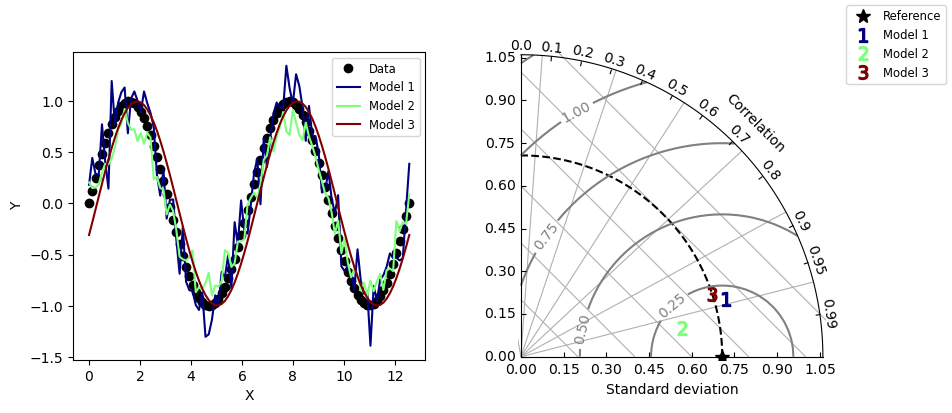

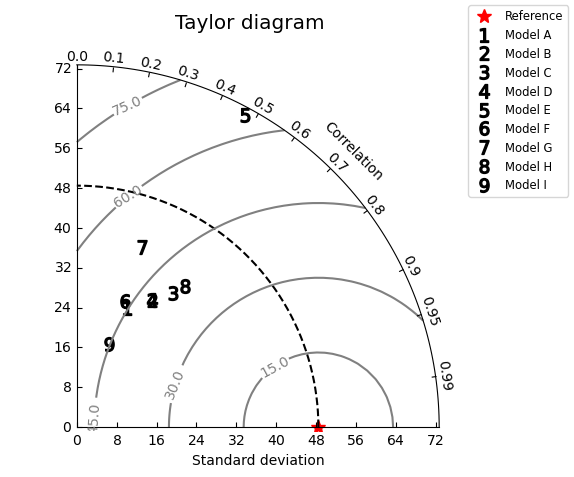

In [2]:
#!/usr/bin/env python

__version__ = "Time-stamp: <2012-02-21 15:52:15 ycopin>"
__author__ = "Yannick Copin <yannick.copin@...547...>"

"""
Taylor diagram (Taylor, 2001) implementation.

Source: http://www-pcmdi.llnl.gov/about/staff/Taylor/CV/Taylor_diagram_primer.htm
"""

import numpy as NP
import matplotlib.pyplot as PLT

class TaylorDiagram(object):
    """Taylor diagram.

    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd, fig=None, rect=111, label='_', srange=(0,1.5)):
        """Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`. 

        Parameters:
        
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = NP.concatenate((NP.arange(10)/10.,[0.95,0.99]))
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str,rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0]*self.refstd
        self.smax = srange[1]*self.refstd

        ghelper = FA.GridHelperCurveLinear(tr,
                                           extremes=(0, NP.pi/2, # 1st quadrant
                                                     self.smin, self.smax),
                                           grid_locator1=gl1,
                                           tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")  # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom") # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")   # "Y axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction("left")

        ax.axis["bottom"].set_visible(False)         # Useless
        
        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, NP.pi/2)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t,r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """Add sample (*stddev*,*corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command."""

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs) # (theta,radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self.ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """Add constant centered RMS difference contours, defined by
        *levels*."""

        rs,ts = NP.meshgrid(NP.linspace(self.smin,self.smax),
                            NP.linspace(0,NP.pi/2))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))
        
        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours

def test1():
    """Display a Taylor diagram in a separate axis."""

    # Reference dataset
    x = NP.linspace(0,4*NP.pi,100)
    data = NP.sin(x)
    refstd = data.std(ddof=1)           # Reference standard deviation

    # Generate models
    m1 = data + 0.2*NP.random.randn(len(x))    # Model 1
    m2 = 0.8*data + .1*NP.random.randn(len(x)) # Model 2
    m3 = NP.sin(x-NP.pi/10)                    # Model 3

    # Compute stddev and correlation coefficient of models
    samples = NP.array([ [m.std(ddof=1), NP.corrcoef(data, m)[0,1]]
                         for m in (m1,m2,m3)])

    fig = PLT.figure(figsize=(10,4))    
    ax1 = fig.add_subplot(1,2,1, xlabel='X', ylabel='Y')

    # Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="Reference")

    colors = PLT.matplotlib.cm.jet(NP.linspace(0,1,len(samples)))
    ax1.plot(x,data,'ko', label='Data')
    for i,m in enumerate([m1,m2,m3]):
        ax1.plot(x,m, c=colors[i], label='Model %d' % (i+1))
    ax1.legend(numpoints=1, prop=dict(size='small'), loc='best')

    # Add the models to Taylor diagram
    for i,(stddev,corrcoef) in enumerate(samples):
        dia.add_sample(stddev, corrcoef, 
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label="Model %d" % (i+1))

    # Add grid
    dia.add_grid()

    # Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    PLT.clabel(contours, inline=1, fontsize=10)

    # Add a figure legend
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')

    return fig
    

def test2():
    """Climatology-oriented example (after iteration w/ Michael
    A. Rawlins)."""

    # Reference std
    stdref = 48.491

    # Samples std,rho,name
    samples = [[25.939, 0.385, "Model A"],
               [29.593, 0.509, "Model B"],
               [33.125, 0.585, "Model C"],
               [29.593, 0.509, "Model D"],
               [71.215, 0.473, "Model E"],
               [27.062, 0.360, "Model F"],
               [38.449, 0.342, "Model G"],
               [35.807, 0.609, "Model H"],
               [17.831, 0.360, "Model I"]]

    fig = PLT.figure()

    dia = TaylorDiagram(stdref, fig=fig, label='Reference')
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i,(stddev,corrcoef,name) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc='k', mec='k',
                       label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5') # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.1f')

    # Add a figure legend and title
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')
    fig.suptitle("Taylor diagram", size='x-large') # Figure title

    return fig

if __name__=='__main__':

    test1()
    test2()

    PLT.show()
    


In [1]:
test1().show()

NameError: name 'test1' is not defined